In [1]:
# ------------------------------------------------------------------------------
# Set training variables
# ------------------------------------------------------------------------------

# System level
import sys
import os
if 'thouis' in os.getcwd():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    import tf_memory_limit


# Arrays
import numpy as np

# Keras (www.keras.io)
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, merge, Concatenate, Maximum, Lambda
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import Constant
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Sklearn (for machine learning)
from sklearn import metrics

# Plots
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
try:
    import seaborn as sns
except:
    pass

import h5py

Using TensorFlow backend.


In [2]:
from astropy.table import Table

In [3]:
metadata = Table.read('/home/thouis/xorastro/big-data/ray_dered.tsv', format='ascii.tab')
images = h5py.File('/home/thouis/xorastro/big-data/imgcube-uint8-all.h5', 'r')['imgcube']

In [4]:
len(metadata), images.shape

(247590, (424, 424, 247590))

In [5]:
metadata.keys()

['id',
 'dr7objid',
 'project_id',
 'location',
 'classification_count',
 'external_ref',
 'created_at',
 'updated_at',
 'region',
 'redshift_bin',
 'magsize_bin',
 'battle_bin',
 'ra_1',
 'dec_1',
 'stripe82',
 'stripe82_coadd',
 'extra_original',
 'objid',
 'ra_2',
 'dec_2',
 'u',
 'g',
 'r',
 'i',
 'z',
 'pred_ug',
 'std_pred_ug',
 'pred_ui',
 'std_pred_ui',
 'pred_uz',
 'std_pred_uz',
 'pred_gi',
 'std_pred_gi',
 'pred_gz',
 'std_pred_gz',
 'pred_iz',
 'std_pred_iz',
 'embed_0',
 'embed_1',
 'u_dered',
 'r_dered',
 'g_dered',
 'i_dered',
 'z_dered']

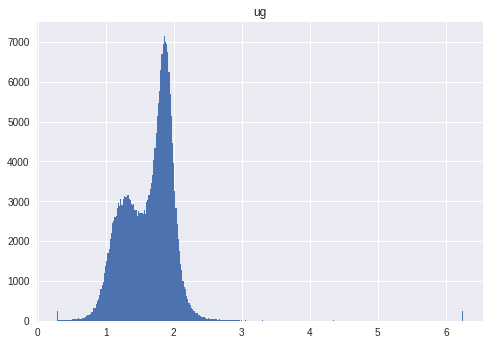

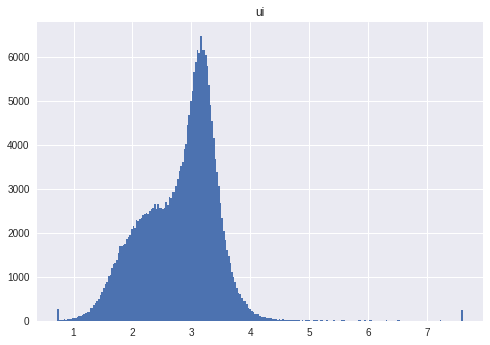

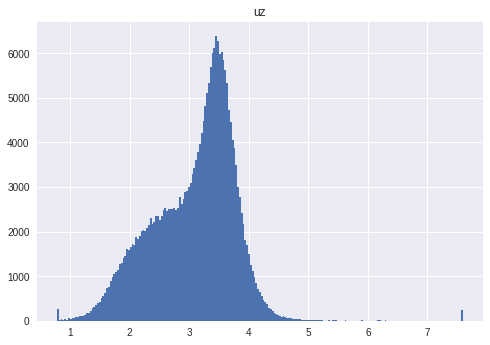

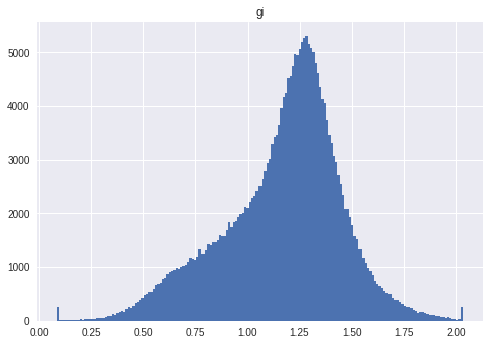

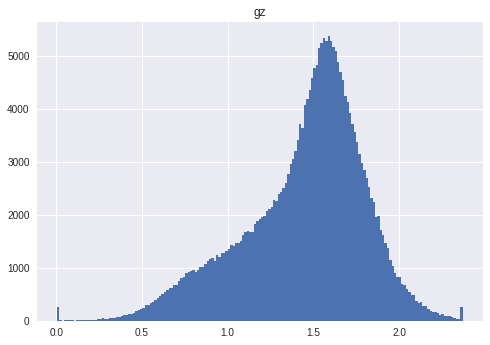

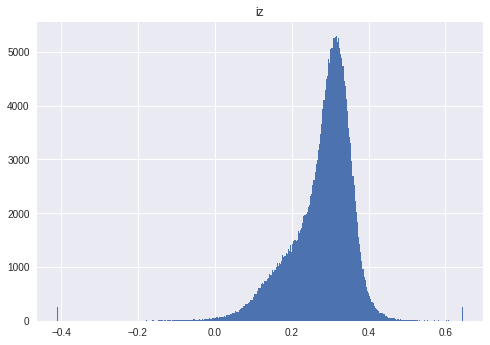

In [6]:
colors = np.array([metadata[:][a + '_dered'] - metadata[:][b + '_dered'] for a, b in 'ug ui uz gi gz iz'.split()]).T
colors.shape

for idx in range(6):
    figure()
    colors[:, idx] = np.clip(colors[:, idx], np.percentile(colors[:, idx], 0.1), np.percentile(colors[:, idx], 99.9))
    hist(colors[:, idx], 'auto')
    title('ug ui uz gi gz iz'.split()[idx])

In [7]:
batch_size = 64

c_train = colors[:int(colors.shape[0] * .8)]
color_mean = c_train.mean(axis=0)
color_std = c_train.std(axis=0)
print("means", color_mean)
print("stds", color_std)

def datagen(lo, hi, batch_size=batch_size):
    batch_ims = []
    batch_colors = []
    while True:
        # To speed things up a bit, I read in a contiguous block
        # of images and generate batches from it by reordering.
        for sidx in range(lo, hi - 1024, 1024):
            subset_images = images[..., sidx:sidx + 1024]
            subset_color = colors[sidx:sidx + 1024, :]
            order = np.random.uniform(0, 1, 1024).argsort()
            for idx in order:
                c = subset_color[idx, :]
                batch_colors.append((c - color_mean) / color_std)
                batch_ims.append(subset_images[:, :, idx])
                if len(batch_colors) == batch_size:
                    yield np.stack(batch_ims, axis=0)[..., np.newaxis], np.stack(batch_colors, axis=0)
                    batch_ims = []
                    batch_colors = []

# separate into 90/10/10 train/validate/test
tenth = int(colors.shape[0] * .1)
train_gen = datagen(0, 8 * tenth)
valid_gen = datagen(8 * tenth, 9 * tenth)
test_gen = datagen(9 * tenth, colors.shape[0])

means [1.63509137 2.80593665 3.08353697 1.17002751 1.44858844 0.27853503]
stds [0.39877845 0.64022831 0.69814162 0.28329394 0.35288847 0.08265393]


(64, 424, 424, 1)
(64, 6)
[0.25943643 0.25475027 0.26900066 0.21341244 0.2386025  0.2875545 ] [0.6505997  0.67078009 0.68895746 0.71586615 0.73273269 0.75590715]


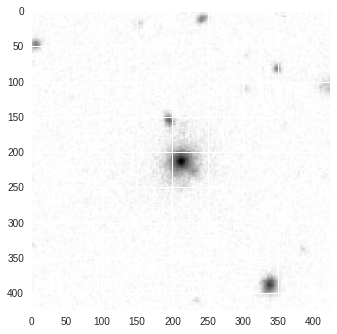

In [8]:
# verify we can sample something
batchims, batchcolors = next(valid_gen)
print(batchims.shape)
print(batchcolors.shape)
imshow(batchims[0, ..., 0])
print(batchcolors.mean(axis=0), batchcolors.std(axis=0))

In [9]:
# ------------------------------------------------------------------------------
# Set up model architecture
# see Figure 4, Figure 8, and Table 2 of Dielemannnnn paper
# ------------------------------------------------------------------------------

# Branch builder
conv00 = Conv2D(filters=32, kernel_size=(6,6), strides=1)
bn00 = BatchNormalization()
conv01 = Conv2D(filters=64, kernel_size=(5,5), strides=1)
bn01 = BatchNormalization()
conv02 = Conv2D(filters=128, kernel_size=(3,3), strides=1)
bn02 = BatchNormalization()
conv03 = Conv2D(filters=128, kernel_size=(3,3), strides=1)
bn03 = BatchNormalization()

# don't use batchnorm for now
bn00 = bn01 = bn02 = bn03 = lambda x: x

def make_branch(x, activation='softplus'):
    def act(v):
        return Activation(activation)(v)
    def pool(v):
        return MaxPooling2D(pool_size=(2, 2))(v)

    c00 = act(bn00(pool(conv00(x))))
    c01 = act(bn01(pool(conv01(c00))))
    c02 = act(bn02(conv02(c01)))
    c03 = act(bn03(pool(conv03(c02))))

    f03 = Flatten()(c03)
    return f03

In [10]:
# Perspective Construction

input_shape = batchims[0].shape

# the image input
image_in = Input(shape=input_shape)

# rotate by 45
rotator = Lambda(lambda x: tf.contrib.image.rotate(image_in, np.pi / 4))
image_45 = rotator(image_in)

# cutout centers
subim_size = 207
input_center = batchims[0].shape[1] // 2
lo = input_center - subim_size // 2
hi = lo + subim_size
cutout = Lambda(lambda x: x[:, lo:hi, lo:hi, :])
subim = cutout(image_in)
subim45 = cutout(image_45)

# downscale 3x3 mean - but allow it to modify the filter
downfilt = Conv2D(filters=1, kernel_size=(3,3), strides=3, kernel_initializer=Constant(1/9), trainable=True)
downsub = downfilt(subim)
downsub45 = downfilt(subim45)

# cut out 4 views from each = 8 views
# tf.image.rot90 would be nice, but it doesn't handle batches of images
view1 = Lambda(lambda x: x[:, :45, :45, :])
view2 = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3])[:, :, ::-1, :][:, :45, :45, :])
view3 = Lambda(lambda x: x[:, ::-1, ::-1, :][:, :45, :45, :])
view4 = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3])[:, ::-1, :, :][:, :45, :45, :])
dsviews = [v(downsub) for v in [view1, view2, view3, view4]]
ds45views = [v(downsub45) for v in [view1, view2, view3, view4]]

# transpose each view = 16 views
transposer = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]))
transposedviews = [transposer(x) for x in dsviews + ds45views]

if False:  # testing
    batchims[0, 211:217, 211:217, 0] = 0
    batchims[0, 205:215, 211:214, 0] = 0

    # debugging - display all the steps and outputs
    m = Model(inputs=[image_in], outputs=[image_in, image_45, subim, subim45, downsub, downsub45] + dsviews + ds45views + transposedviews)
    outs = m.predict_on_batch(batchims)
    for o in outs:
        figure()
        imshow(o[0, ..., 0])
        title(str(o[0, ..., 0].shape))


allviews = dsviews + ds45views + transposedviews

In [ ]:
# now set up the 16-way branching
merge = Maximum()
branches = [make_branch(x) for x in allviews]
merged_outputs = merge(branches)

# Dense layers
mergedrop = Dropout(0.5)(merged_outputs)
d0 = Dropout(0.5)((Dense(512, activation='relu')(mergedrop)))
d1 = Dropout(0.5)((Dense(512, activation='relu')(d0)))
dbottle = Dense(2)(d1)
drecon1 = Dense(16, activation='relu')(dbottle)
drecon2 = Dense(16, activation='relu')(drecon1)
drecon3 = Dense(16, activation='relu')(drecon2)

#output layer
last_dense = Dense(6)
y = last_dense(drecon3)

model = Model(inputs=[image_in], outputs=[y])

# Seems to work better with Adam for me, but SGD+momentum is probably just as good when tuned.
# optimizer = SGD(lr=0.001, momentum=0.9, decay=1e-5)
optimizer = Adam(decay=1e-5)

loss = 'mean_absolute_error'  # MSE was giving me stability issues during training
model.compile(loss=loss, optimizer=optimizer, metrics=['mean_squared_error'])
# model.summary()

In [ ]:
num_batch_train = int(colors.shape[0] * 0.8 / batch_size)
num_batch_valid = int(colors.shape[0] * 0.1 / batch_size)

train_or_load = 'train'

if train_or_load == 'train':
    checkpointer = ModelCheckpoint(filepath='dered_all_diffs.model.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

    hist = model.fit_generator(train_gen, epochs=30, steps_per_epoch=num_batch_train, validation_data=valid_gen, validation_steps=num_batch_valid, verbose=2, callbacks=[checkpointer])
else:
    model.load_weights('all_diffs.model.15-0.44.hdf5')

Epoch 1/30


In [ ]:
submodel = Model(inputs=[image_in], outputs=[dbottle])

all_embeds = []
for bidx in range(0, images.shape[2], batch_size):
    batch = images[:, :, bidx:bidx + batch_size].transpose((2, 0, 1))[..., np.newaxis]
    all_embeds.append(submodel.predict_on_batch(batch))

all_embeds = np.concatenate(all_embeds)
assert all_embeds.shape[0] == images.shape[2]

In [58]:
num_train = int(colors.shape[0] * .8)
train_embeds = all_embeds[:num_train, :]
num_val = int(colors.shape[0] * .1)
val_embeds = all_embeds[num_train:, :][:num_val, :]

train_gt = colors[:num_train, :]
val_gt = colors[num_train:, :][:num_val, :]

In [59]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=100)
regressor.fit(train_embeds, train_gt)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=100, p=2,
          weights='uniform')

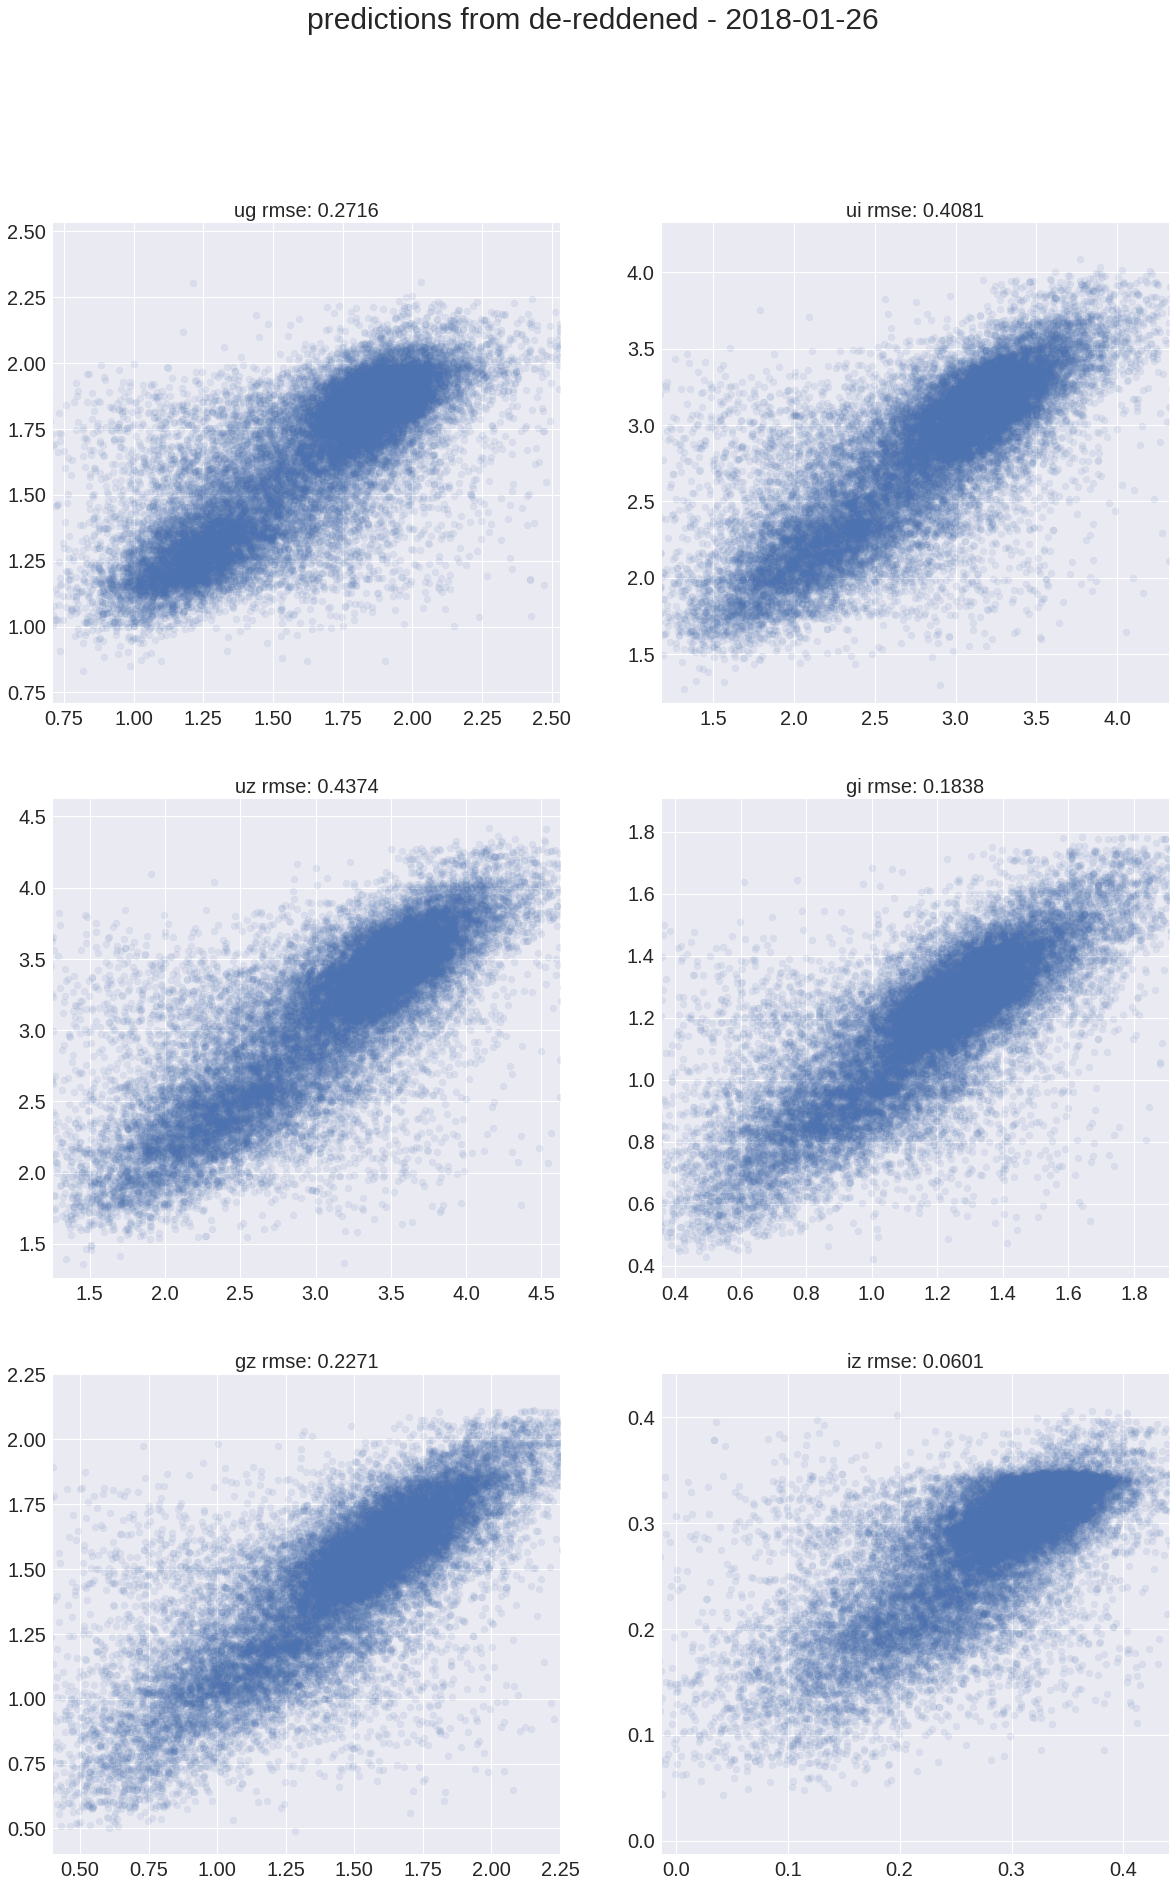

In [60]:
preds = regressor.predict(val_embeds)
diffs = val_gt - preds

params = {'legend.fontsize': '40',
         'axes.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20'}
pylab.rcParams.update(params)


# plot true vs predictions
figure(figsize=(20, 30))
suptitle('predictions from de-reddened - 2018-01-26', fontsize=30)
for idx, name in enumerate('ug ui uz gi gz iz'.split()):
    subplot(3, 2, idx + 1)
    scatter(val_gt[:, idx], preds[:, idx], alpha=0.1)
    lo = np.percentile(val_gt[:, idx], 0.5)
    hi = np.percentile(val_gt[:, idx], 99.5)
    xlim(lo, hi)
    ylim(lo, hi)
    rmse = np.sqrt(((val_gt[:, idx] - preds[:, idx]) ** 2).mean())
    title("{} rmse: {:.4f}".format(name, rmse))

In [53]:
# predict everything
allpreds = regressor.predict(all_embeds)

# estimate per-shift std from neighbors
all_pred_stds = []

for bidx in range(0, colors.shape[0], 10000):
    neighbor_indices = regressor.kneighbors(all_embeds[bidx:bidx+10000, :], return_distance=False)
    stds = []
    for chan in range(6):
        vals = train_gt[neighbor_indices, chan]
        assert vals.shape == neighbor_indices.shape
        stds.append(vals.std(axis=1))
    all_pred_stds.append(np.stack(stds, axis=0).T)
all_pred_stds = np.concatenate(all_pred_stds)

In [55]:
for idx, name in enumerate('ug ui uz gi gz iz'.split()):
    metadata['pred_dered_' + name] = allpreds[:, idx]
    metadata['std_pred_dered_' + name] = all_pred_stds[:, idx]
metadata['embed_0'] = all_embeds[:, 0]
metadata['embed_1'] = all_embeds[:, 1]

In [56]:
metadata.write('metadata_dered_with_preds.tsv', format='ascii.tab')

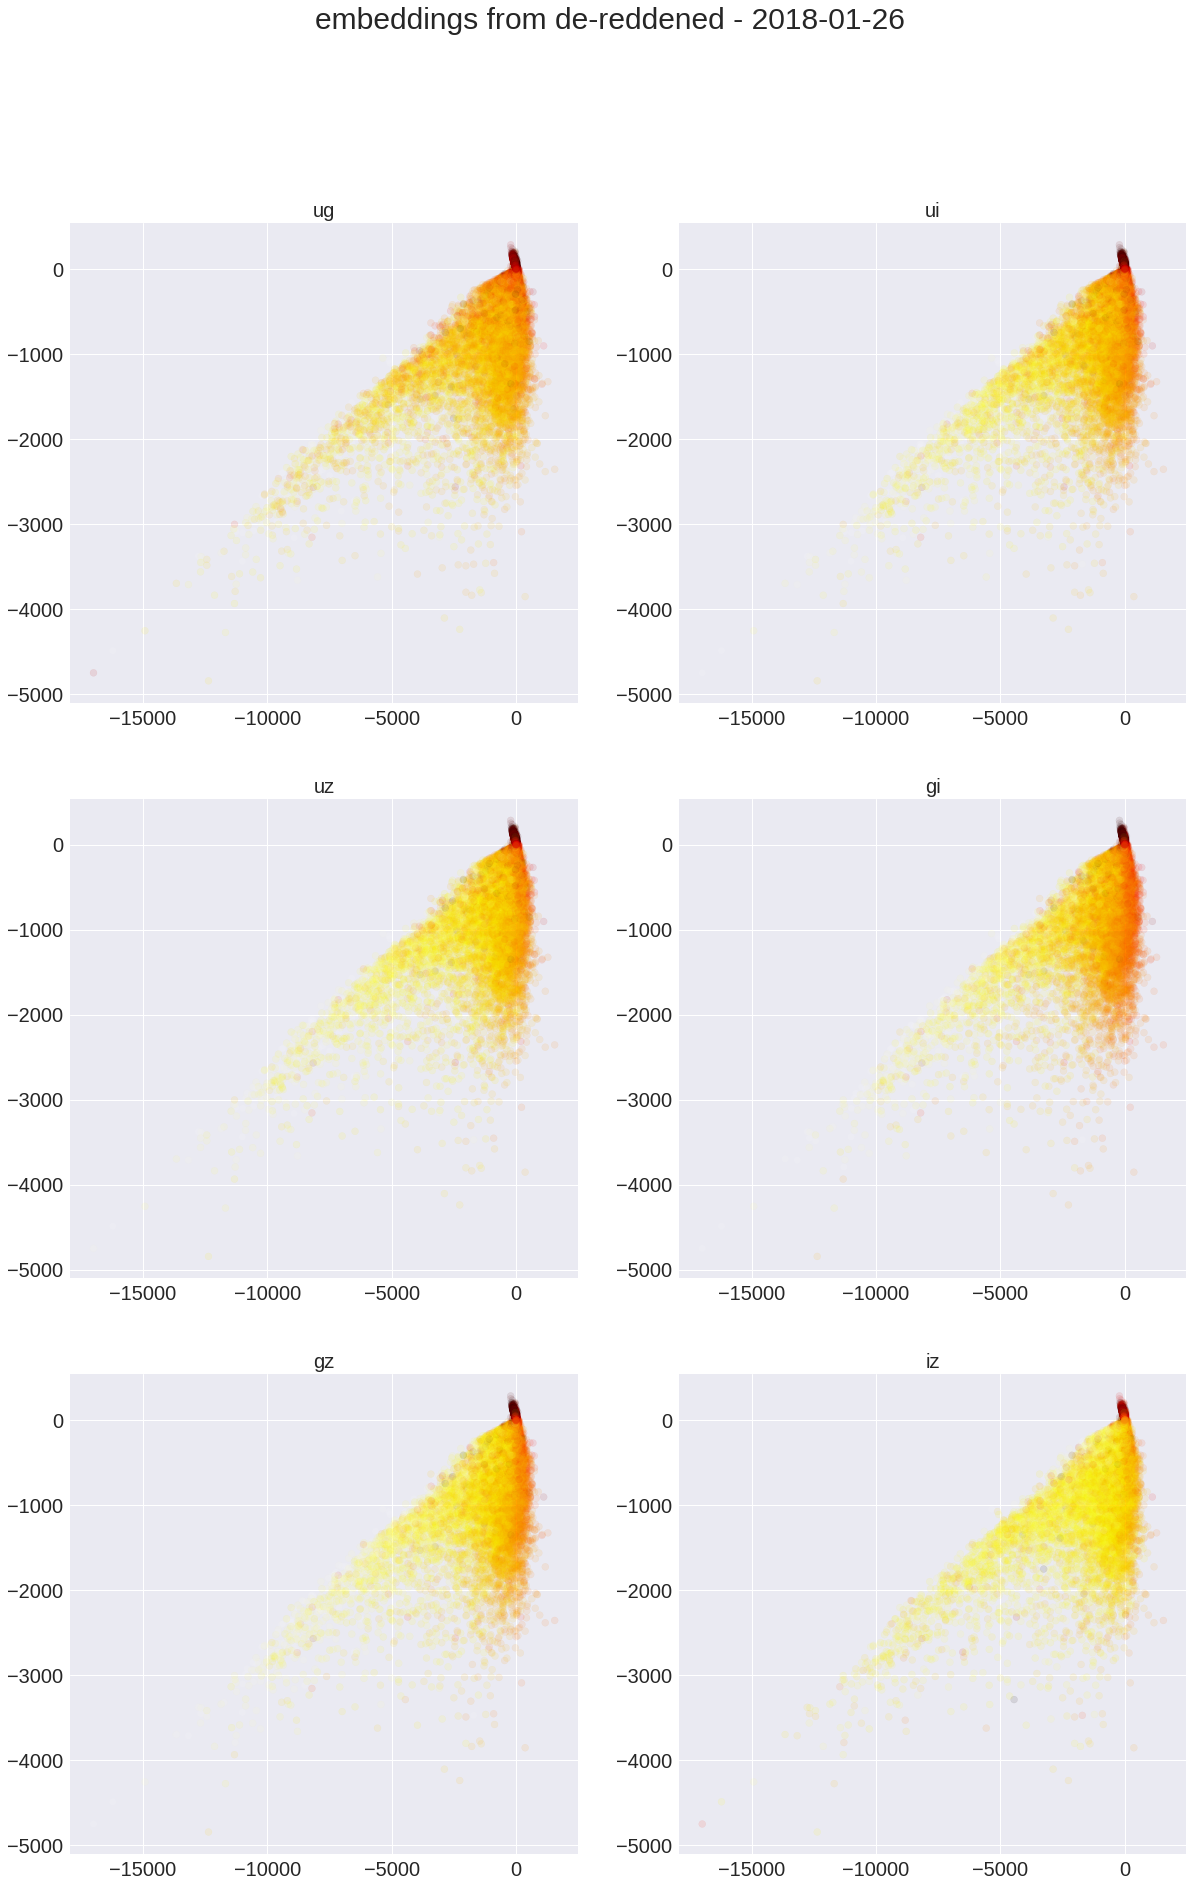

In [61]:
# plot embeddings
figure(figsize=(20, 30))
suptitle('embeddings from de-reddened - 2018-01-26', fontsize=30)
for idx, name in enumerate('ug ui uz gi gz iz'.split()):
    subplot(3, 2, idx + 1)
    lo = percentile(val_gt[:, idx], 0.5)
    hi = percentile(val_gt[:, idx], 99.5)
    scatter(val_embeds[:, 0], val_embeds[:, 1], c=clip(val_gt[:, idx], lo, hi), alpha=0.1, cmap='hot')
    title("{}".format(name))

In [51]:
# what fraction of galaxies are in that little "thumb"?
(val_embeds[:, 1] > 0).mean()

0.22072781614766349